In [351]:
import math
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

In [352]:
def smoothen(waypoints):
    optimumpointlist = []
    i = 0
    range_factor = 6
    avg_factor = 2 * range_factor + 1
    num_of_waypoints = len(waypoints)

    for point in waypoints:
        counter = 0
        estimated_x_cord = point[0]
        estimated_y_cord = point[1]
        while counter < range_factor:
            estimated_x_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][0]
            estimated_x_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][0]

            estimated_y_cord += waypoints[(i + (counter + 1)) % num_of_waypoints][1]
            estimated_y_cord += waypoints[(i - (counter + 1)) % num_of_waypoints][1]
            counter += 1

        estimated_x_cord = estimated_x_cord / avg_factor
        estimated_y_cord = estimated_y_cord / avg_factor


        optimumpointlist.append(np.array( (estimated_x_cord, estimated_y_cord) ))

        i += 1
    return np.array(optimumpointlist)

In [353]:
def calc_distance(prev_point, next_point):
    delta_x = next_point[0] - prev_point[0]
    delta_y = next_point[1] - prev_point[1]
    return math.hypot(delta_x, delta_y)

def smooth_central_line(center_line, max_offset, pp=0.10, p=0.05, c=0.70, n=0.05, nn=0.10, iterations=72, skip_step=1):
    if max_offset < 0.0001:
        return center_line
    if skip_step < 1:
        skip_step = 1
    smoothed_line = center_line
    for i in range(0, iterations):
        smoothed_line = smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step)
    return smoothed_line


def smooth_central_line_internal(center_line, max_offset, smoothed_line, pp, p, c, n, nn, skip_step):
    length = len(center_line)
    new_line = [[0.0 for _ in range(2)] for _ in range(length)]
    for i in range(0, length):
        wpp = smoothed_line[(i - 2 * skip_step + length) % length]
        wp = smoothed_line[(i - skip_step + length) % length]
        wc = smoothed_line[i]
        wn = smoothed_line[(i + skip_step) % length]
        wnn = smoothed_line[(i + 2 * skip_step) % length]
        new_line[i][0] = pp * wpp[0] + p * wp[0] + c * wc[0] + n * wn[0] + nn * wnn[0]
        new_line[i][1] = pp * wpp[1] + p * wp[1] + c * wc[1] + n * wn[1] + nn * wnn[1]
        while calc_distance(new_line[i], center_line[i]) >= max_offset:
            new_line[i][0] = (0.98 * new_line[i][0]) + (0.02 * center_line[i][0])
            new_line[i][1] = (0.98 * new_line[i][1]) + (0.02 * center_line[i][1])
    return new_line

In [354]:
from scipy import signal
def up_sample(waypoints, factor):
    """
    Adds extra waypoints in between provided waypoints
    :param waypoints:
    :param factor: integer. E.g. 3 means that the resulting list has 3 times as many points.
    :return:
    """
    return np.array( list( signal.resample(np.array(waypoints), len(waypoints) * factor) ) )

In [418]:
TRACK_NAME = 'C:/Users/suraj/projects/deepracer24/2022_may_open_ccw.npy'

# Load the center, inner, outer waypoints
waypoints = np.load(TRACK_NAME)

center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]

center_line = up_sample(center_line, 1)

In [419]:
# smooth_path = smoothen(center_line)
smooth_path = smooth_central_line( center_line, 1.066*0.85*0.5,skip_step=1 )
smooth_path = np.array( [ np.array(point) for point in smooth_path ] )
# smooth_path = up_sample(smooth_path, 10)

In [420]:
1.066*0.85*0.5

0.45305

In [421]:
smooth_path.shape

(156, 2)

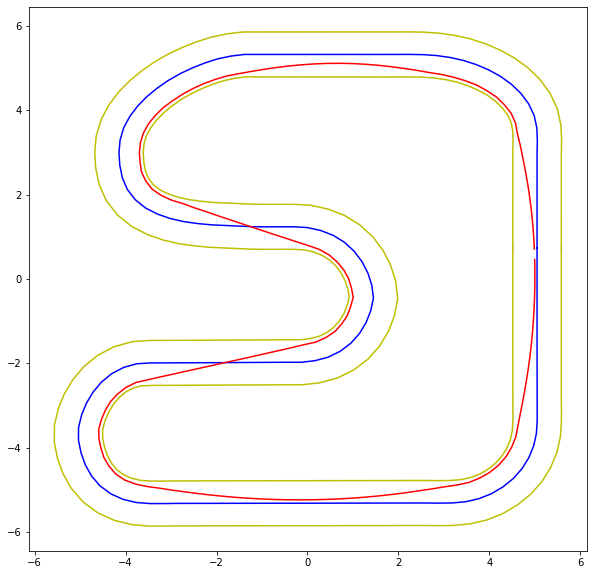

In [422]:
plt.plot(center_line[:,0], center_line[:,1], label = 'center_line', c = 'b')
plt.plot(inner_border[:,0], inner_border[:,1], label = 'inner_border', c = 'y')
plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'y')
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'smooth_path', c = 'r')
# plt.plot(smooth_path[10:12,0], smooth_path[10:12,1], label = 'smooth_path_subsection', c = 'k')
# for i in range(0, 21):
#     plt.scatter( center_line[i][0], center_line[i][1], label = 'cl'.format(i), s = 10, c = 'k' )
#     plt.scatter( smooth_path[i][0], smooth_path[i][1], label = 'sl'.format(i), s = 10, c = 'r' )
#plt.scatter( center_line[10][0]+0.4, center_line[10][1], label = 'random_point', s = 10, c = 'k' )
# plt.legend()
plt.show()

In [360]:
p1 = smooth_path[10][0], smooth_path[10][1]
p2 = smooth_path[11][0], smooth_path[11][1]
p3 = center_line[10][0]+4, center_line[10][1]
distanceFromLine( p1, p2, p3 )

4.0000003794540175

In [361]:
# Calculate distance between current point and closest point on line between prev_point and next_point
def calc_distance_from_line(curr_point, prev_point, next_point):
    distance_cp_to_pp = calc_distance(curr_point, prev_point)  # b
    distance_cp_to_np = calc_distance(curr_point, next_point)  # a
    distance_pp_to_np = calc_distance(prev_point, next_point)  # c
    # cos A = (b^2 + c^2 - a^2) / 2bc
    angle_pp = math.acos((distance_cp_to_pp * distance_cp_to_pp + distance_pp_to_np * distance_pp_to_np
                          - distance_cp_to_np * distance_cp_to_np) / (2 * distance_cp_to_pp * distance_pp_to_np))
    # b / sin(Pi/2) = d / sin(A)
    return distance_cp_to_pp * math.sin(angle_pp)

In [362]:
calc_distance_from_line( p3, p1, p2 )

4.0000003794540175

In [363]:
import math

def angle(p1, p2):
    """
    """
    dy = p2[1]-p1[1]
    dx = p2[0]-p1[0]
    return math.degrees(math.atan2(dy,dx))

def normalize_angle_to_360(angle):
    if angle < 0:
        return 360 + angle
    return angle

In [364]:
x1, y1 = 0, 0
x2, y2 = 0, -1

In [365]:
normalize_angle_to_360( angle((x1,y1), (x2,y2)) )

270.0

In [366]:
center_line[:10]

array([[5.04771315, 0.73385354],
       [5.0477069 , 0.73904175],
       [5.04770087, 0.74642755],
       [5.04769566, 0.75600261],
       [5.04769176, 0.76764572],
       [5.04768959, 0.78113405],
       [5.04768936, 0.79616038],
       [5.04769112, 0.81235497],
       [5.0476947 , 0.82931082],
       [5.04769972, 0.8466106 ]])

In [367]:
up_sample(center_line, 10).shape

(15600, 2)

In [368]:
smoothen(up_sample(center_line, 10)).shape

(15600, 2)

In [369]:
center_line.shape

(1560, 2)

In [554]:
def distanceReward(p1, p2, p3):
    '''
    calc the perpendicular dist of point p3 from the line passing through point p1 and p2
    '''
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3

    a = y1-y2
    b = x2-x1
    c = (x1-x2)*y1 + (y2-y1)*x1

    distance = abs( a*x3 + b*y3 + c )/math.sqrt( a**2 + b**2 )
    value = 10/( (1+float(distance))**8 )
    return value

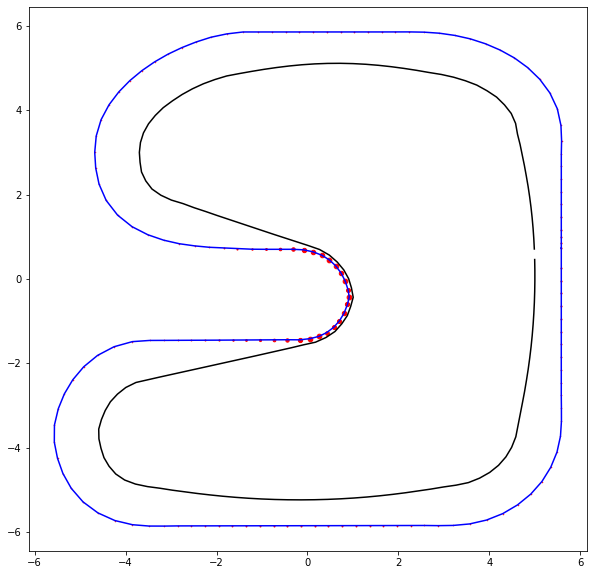

In [557]:
plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'b')
dr = []
for i, point in enumerate(outer_border[:-2]):
    reward = distanceReward( smooth_path[i+1], smooth_path[i+2], point )
    dr.append(reward)
    plt.scatter(point[0], point[1], s = reward*5, c = 'r')
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'smooth_path', c = 'k')
plt.show()

In [558]:
print( min(dr) )
print( max(dr) )

0.04354907862909292
4.581300311147566


In [372]:
distanceFromLine(p1, p2, p3)

0.7071067811865475

In [373]:
cl = [ list(p) for p in center_line ]

In [374]:
cl.index([5.047791957855225, 2.0704389810562134])

60

In [375]:
def calculate_angle(p1, p2, p3):
    # Calculate the angle between three points p1, p2, p3
    angle = math.degrees(
        math.atan2(p3[1] - p2[1], p3[0] - p2[0]) - math.atan2(p1[1] - p2[1], p1[0] - p2[0])
    )
    return angle % 360

def shape_complexity(coordinates):
    num_angles = len(coordinates) - 2
    total_angle_sum = 0

    for i in range(num_angles):
        x1, y1 = coordinates[i]
        x2, y2 = coordinates[i + 1]
        x3, y3 = coordinates[i + 2]

        angle = calculate_angle(x1, y1, x2, y2, x3, y3)
        total_angle_sum += angle

    # Calculate the average angle to assess shape complexity
    average_angle = total_angle_sum / num_angles

    # Higher average angle indicates a more complex shape
    return average_angle

In [376]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def fit_in_range( x, lower = -100, upper = 100 ):
    return lower + (sigmoid(x) - 0) * (upper - lower) / (1 - 0)

In [377]:
def angle(p1, p2):
    """
    """
    dy = p2[1]-p1[1]
    dx = p2[0]-p1[0]
    return math.degrees(math.atan2(dy,dx))

In [378]:
def diffrentiate( signal ):
    x = [p[0] for p in signal]
    y = [p[1] for p in signal]
    dy = [y[i+1]-y[i] for i in range(len(y)-1)]
    dx = [x[i+1]-x[i] for i in range(len(x)-1)]
    dy_by_dx = [ dy/dx for dy, dx in zip(dy, dx) ]
    return [ (x, y) for x,y in zip( x[:len(dy_by_dx)], dy_by_dx ) ]

In [516]:
def get_turn_points(coordinates):
    turn_points = []
    angle_change = []
    window_size = 8
    threshold_angle = 4.5  # Set a threshold angle to determine a significant turn

    for i in range(len(coordinates) - window_size + 1):
        window = coordinates[i : i + window_size]
        angles = [
            calculate_angle(window[j], window[j + 1], window[j + 2]) for j in range(window_size - 2)
        ]
        max_angle_change = abs( max(angles) - min(angles) )
        if max_angle_change >= threshold_angle:
            turn_points.append(coordinates[i])
            angle_change.append(abs(max_angle_change))
    return turn_points, angle_change

In [517]:
def angle_between_points(first_point, second_point, third_point):
    """Calculates the angle between two line segments formed by three points."""
    first_dx = second_point[0] - first_point[0]
    first_dy = second_point[1] - first_point[1]
    third_dx = first_point[0] - third_point[0]
    third_dy = first_point[1] - third_point[1]
    angle = math.atan2(third_dy, third_dx) - math.atan2(first_dy, first_dx)
    return math.degrees(angle)

# def get_turn_points(waypoints):
#     turn_points = []
#     for i, point in enumerate(waypoints):
#         next_3 = [ waypoints[(i+1)%len(waypoints)] for i in range(3) ]
#         try:
#             angle = angle_between_points(next_3[0], next_3[1], next_3[2])
#             if abs(angle) > 180:
#                 turn_points.append(point)
#         except Exception as ex:
#             print( i, point, ex )
#     return turn_points


In [518]:
# def calculate_angle(p1, p2, p3):
#     # Calculate the angle between three points p1, p2, p3
#     angle = math.degrees(
#         math.atan2(p3[1] - p2[1], p3[0] - p2[0]) - math.atan2(p1[1] - p2[1], p1[0] - p2[0])
#     )
#     return angle % 360

def getAngle(a, b, c):
    ang = math.degrees(math.atan2(c[1]-b[1], c[0]-b[0]) - math.atan2(a[1]-b[1], a[0]-b[0]))
    return ( ang + 360 if ang < 0 else ang )

In [519]:
getAngle((1,1), (0,0), (1,-0.5))

288.434948822922

In [520]:
tp, ac = get_turn_points(center_line[:])

In [521]:
print( min(ac) )
print( max(ac) )

4.63232589770837
13.562838677485416


In [533]:
optimal_speed = 4 - (0 / 14) * (4 - 1.5)

# Calculate reward for speed
speed_diff = abs(1.5 - optimal_speed)
reward_speed = math.exp(-0.5 * speed_diff)

print(optimal_speed)
print(speed_diff)
print(reward_speed)

4.0
2.5
0.2865047968601901


ValueError: s must be a scalar, or float array-like with the same size as x and y

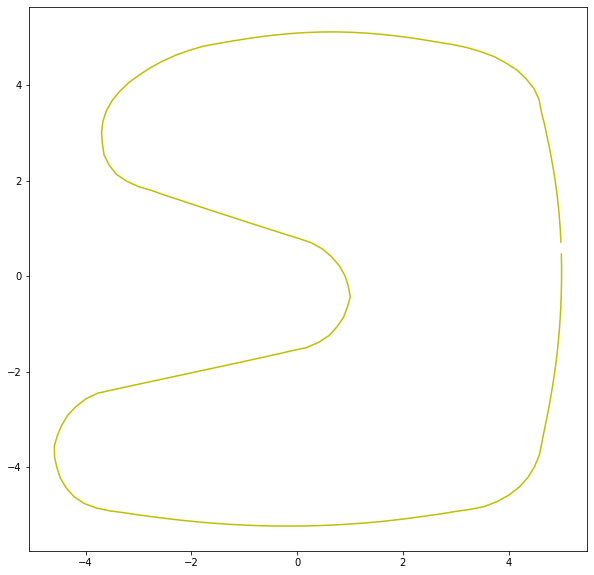

In [525]:
plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'center_line', c = 'y')
# plt.plot(inner_border[:,0], inner_border[:,1], label = 'inner_border', c = 'b')
# plt.plot(outer_border[:,0], outer_border[:,1], label = 'outer_border', c = 'b')
# plt.plot(smooth_path[:,0], smooth_path[:,1], label = 'smooth_path', c = 'r')
# plt.plot(smooth_path[10:12,0], smooth_path[10:12,1], label = 'smooth_path_subsection', c = 'k')
# for i in range(0, 21):
#     plt.scatter( center_line[i][0], center_line[i][1], label = 'p_{}'.format(i), s = 10, c = 'k' )
#plt.scatter( center_line[10][0]+0.4, center_line[10][1], label = 'random_point', s = 10, c = 'k' )

for p in get_turn_points(smooth_path):
    point = p[0]
    diff = p[1]
    plt.scatter( point[0], point[1], s = diff*5, c = 'k' )

plt.legend()
plt.show()

In [381]:
def normalize_reward(reward):
    sign = 1 if reward >=0 else -1
    if reward == 0:
        return 0
    if reward <=0:
        reward = 1/(1 + np.exp(-np.abs(reward)/1000) )
    if reward >=0:
        reward = (math.log2(reward)*2)/(1 + np.exp(-np.abs(reward)/100) )
    reward = reward**2
    reward = sign*(1 - reward) if sign < 0 else reward
    return reward

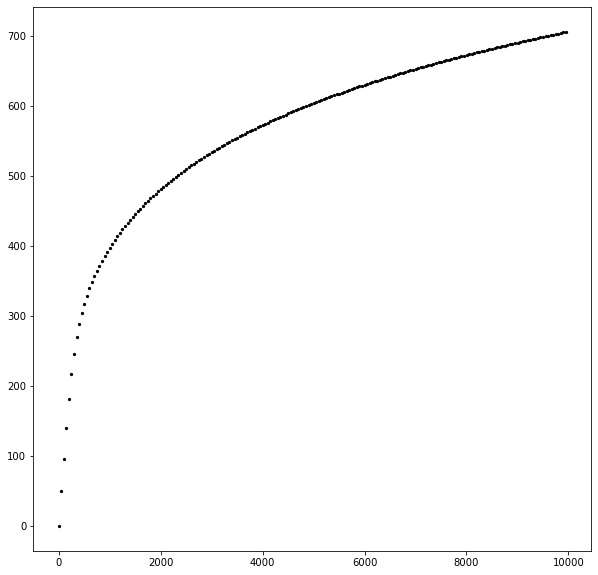

In [412]:
for x in range( 1, 10000, 50):
    plt.scatter( x, normalize_reward(x), c = 'k', s = 5 )
plt.show()

In [383]:
rewards = [2300, 1800, 161, 94, 24, -24, -94, -1800, -2300]
for r in rewards:
    print(normalize_reward(r))

498.84491207302614
467.7514403583875
149.3122504432363
88.86465619377903
26.342886640980296
-0.029227288505335736
-0.12347282063276521
-0.9508726066003852
-0.9808262321356962


In [384]:
normalize_reward(10000000000)

4414.082507040793

In [396]:
5.95**2

35.4025

In [397]:
0.95**2

0.9025

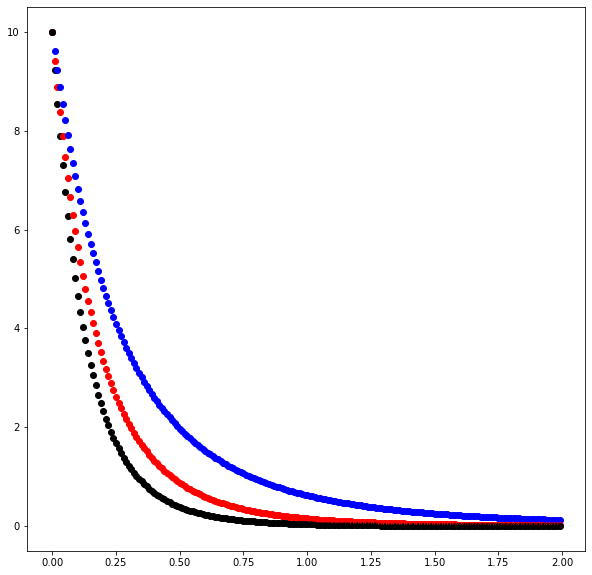

In [553]:
for d in range(0, 200):
    d = d/100
    plt.scatter( d, 10/( (1+float(d))**4 ), c = 'b' )
    plt.scatter( d, 10/( (1+float(d))**6 ), c = 'r' )
    plt.scatter( d, 10/( (1+float(d))**8 ), c = 'k' )
plt.show()

In [411]:
d = 0
prev_point = None
for point in smooth_path:
    if prev_point is None:
        prev_point = point
        continue
    d+=calc_distance(prev_point, point)
    prev_point = point
d

40.74798007337753

In [423]:
import math

In [430]:
direction_diff = 20

math.cos( abs(direction_diff ) * ( math.pi / 180 ) ) ** 4

0.7797282437678554